In [1]:
import tensorflow as tf 
import cv2 as cv
import numpy as np 
from matplotlib import pyplot as plt
import random

2023-09-12 15:37:04.009191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:37:08.569638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:37:08.580915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 15:37:17.109201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# IMPORTING DATA

In [2]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.cifar100.load_data()

# ANALYZING AND VISUALIZING THE DATA

In [3]:
train_images.shape

(50000, 32, 32, 3)

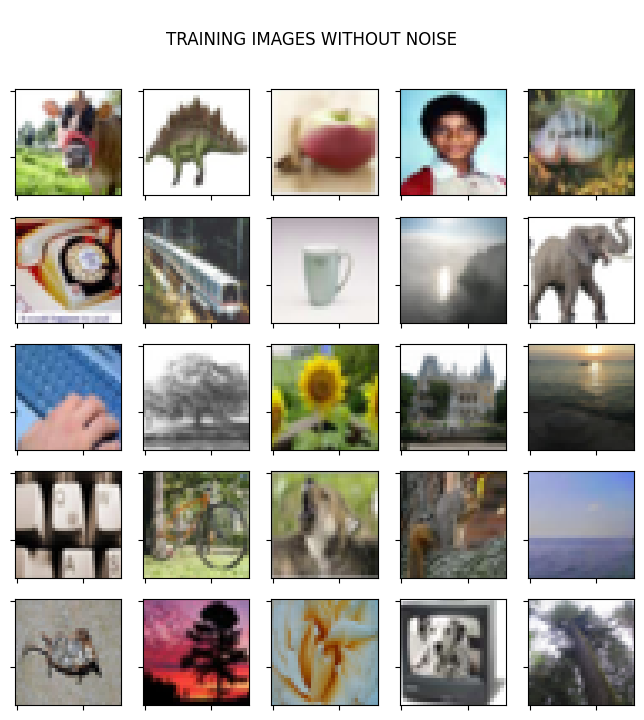

In [4]:
fig,axes = plt.subplots(nrows = 5,ncols = 5,figsize = (8,8))
row=0
col = 0
for i in range(25):
    if i%5==0 and i!=0:
       row+=1
       col = 0
       axes[row][col].imshow(train_images[i])
       axes[row][col].set_xticklabels([])
       axes[row][col].set_yticklabels([])
       col+=1
       continue
    axes[row][col].imshow(train_images[i])
    axes[row][col].set_xticklabels([])
    axes[row][col].set_yticklabels([])
    col+=1
fig.suptitle("\nTRAINING IMAGES WITHOUT NOISE ")
plt.show()

# ADDING NOISE TO MAKE THE DATASET

In [32]:
noise = 0.3
train_noise_images = (train_images/255) + noise*np.random.normal(0,0.3,size = train_images.shape)
train_noise_images = np.clip(train_noise_images,0,1)

## VISUALIZING THE NOISY DATASET 

/tmp/ipykernel_6763/2980776214.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


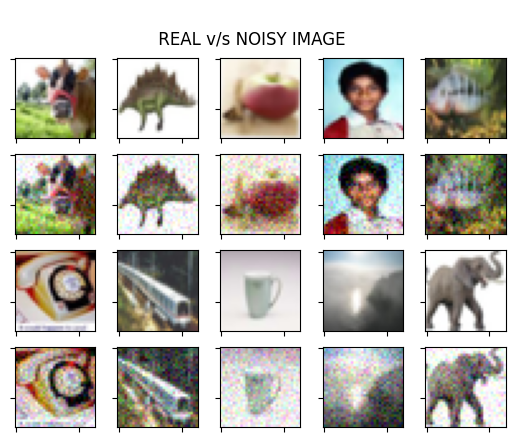

In [33]:
fig,axes = plt.subplots(nrows=4,ncols=5)
row = 0
col = 0
for i in range(10):
    if i == 5 :
        row+=2
        col=0
        axes[row][col].imshow(train_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
        continue
    else:
        axes[row][col].imshow(train_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
col = 0
row = 1
for i in range(10):
    if i == 5 :
        row+=2
        col=0
        axes[row][col].imshow(train_noise_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
        continue
    else:
        axes[row][col].imshow(train_noise_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.suptitle("\n REAL v/s NOISY IMAGE \n")
fig.savefig("Data visualzied.png")
fig.show()

## MAKING THE TEST DATASET

In [34]:
test_noisy_images = (test_images/255) + noise*np.random.normal(0,0.3,size=test_images.shape) 
test_noisy_images = np.clip(test_noisy_images,0,1)